# Objective

The objective of this notebook is to compare different bispecific T cell engagers (BiTEs) based on their target concentrations and binding dissociation rates.

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, DataFrames

# Database

Let's available a dataframe for the BiTE molecules with published information.

In [2]:
df = DataFrame(molecule = ["Blinatumomab", "Solitomab", "7370", "BAY2010112", "PF-06671008","PF-07062119", "Tarlatamab", "Acapatamab", "Anti-CD79b/CD3"],
               kD1 = [100, 16,   27, 9.4,   11.5,  7.47, 0.64, 22.4, 12.8],
               kD2 = [1,   77,0.049,47.0, 0.521, 23.97, 14.9, 14.8, 1],
               weight_kDa = [55,55, 146, 55, 57, ">100", ">100", ">100", 150],
               format = ["BiTE", "BiTE", "IgG-based", "BiTE", "DART","IgG1-FcyR","HLE-BiTE", "HLE-BiTE", "KIH"],
               tumor_type = ["Liquid", "Liquid", "Liquid","Solid", "Solid", "Solid", "Solid", "Solid", "Liquid"],
               target_1 = ["CD3", "CD3","CD3", "CD3", "CD3", "CD3", "CD3", "CD3", "CD3"],
               target_2 = ["CD19", "Ep-CAM", "FLT3", "PSMA", "Pcad", "GUCY2C", "DLL3", "PSMA", "CD79b"]
               )

9×8 DataFrame
 Row │ molecule        kD1      kD2      weight_kDa  format     tumor_type  ta ⋯
     │ String          Float64  Float64  Any         String     String      St ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Blinatumomab     100.0     1.0    55          BiTE       Liquid      CD ⋯
   2 │ Solitomab         16.0    77.0    55          BiTE       Liquid      CD
   3 │ 7370              27.0     0.049  146         IgG-based  Liquid      CD
   4 │ BAY2010112         9.4    47.0    55          BiTE       Solid       CD
   5 │ PF-06671008       11.5     0.521  57          DART       Solid       CD ⋯
   6 │ PF-07062119        7.47   23.97   >100        IgG1-FcyR  Solid       CD
   7 │ Tarlatamab         0.64   14.9    >100        HLE-BiTE   Solid       CD
   8 │ Acapatamab        22.4    14.8    >100        HLE-BiTE   Solid       CD
   9 │ Anti-CD79b/CD3    12.8     1.0    150         KIH        Liquid      CD ⋯
                                                               2 columns omitted

# Steady state response

Considering the three-body model at the site of action.

In [3]:
function ss(du,u,p,t)
    X, T₁, T₂, D₁, D₂, Y = u
    kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kn₁*T₁*X -kn₂*T₂*X +kf₁*D₁ +kf₂*D₂
    du[2]= -kn₁*T₁*X +kf₁*D₁ -kn₁*T₁*D₂ +kf₁*Y
    du[3]= -kn₂*T₂*X +kf₂*D₂ -kn₂*T₂*D₁ +kf₂*Y
    du[4]= +kn₁*T₁*X -kf₁*D₁ -kn₂*T₂*D₁ +kf₂*Y
    du[5]= +kn₂*T₂*X -kf₂*D₂ -kn₁*T₁*D₂ +kf₁*Y
    du[6]= +kn₁*T₁*D₂ +kn₂*T₂*D₁ -(kf₁+kf₂)*Y
end

initconc = [1e0,1.08e-1,166,0.0,0.0,0.0]
timespan = (0.0,0.5)
kinetics = [1,11.5,1,0.52] # keeping kon values constant
dproblem = ODEProblem(ss,initconc,timespan,kinetics)

function bellshape(problem_,kd_,conc_)
    gridsize = 10000
    drugconc = 10 .^range(-6,+8,length=gridsize) 
    ssvalues = zeros(gridsize)
    kinetics = [1,kd_[1],1,kd_[2]] 
    for index=1:length(drugconc) 
        problemi = remake(problem_, tspan=(0.0, 1e3), p=kinetics
            , u0=vcat(drugconc[index], conc_[:], 0, 0, 0))
        solution = solve(problemi)
        ssvalues[index] = solution[6,end]'
    end
    return [drugconc, ssvalues]
end

bellshape (generic function with 1 method)

## BiTEs for solid tumor

In [4]:
function solid(df_, name_)
    p1 = plot(title="1:10", xlabel="BiTE Conc. (nM)", ylabel="Trimer Conc. (nM)")
    p2 = plot(title="1:100", xlabel="BiTE Conc. (nM)", ylabel="Trimer Conc. (nM)")
    p3 = plot(title="1:1000", xlabel="BiTE Conc. (nM)", ylabel="Trimer Conc. (nM)")
    for i=1:size(df_,1)
        kinetics = [df_.kD1[i], df_.kD2[i]]
        drugconc, ssvalues = bellshape(dproblem,kinetics,[1, 10])
        p1 = plot!(p1, drugconc, ssvalues, xscale=:log10, label=df_.molecule[i], linewidth=3)
        drugconc, ssvalues = bellshape(dproblem,kinetics,[1e-1, 10])
        p2 = plot!(p2, drugconc, ssvalues, xscale=:log10, label=df_.molecule[i], linewidth=3)
        drugconc, ssvalues = bellshape(dproblem,kinetics,[1e-1, 100])
        p3 = plot!(p3, drugconc, ssvalues, xscale=:log10, label=df_.molecule[i], linewidth=3)
    end
    p = plot(p1,p2,p3,layout=(3,1), size=(400,900), margin=5mm)
    savefig(p, "figures/"*name_*".png")
    savefig(p, "figures/"*name_*".pdf")
    display(p)
end

solid(df[df.tumor_type .=="Solid",:], "solid")

## BiTEs for liquid tumor

In [5]:
function liquid(df_, name_)
    p1 = plot(title="10:1", xlabel="BiTE Conc. (nM)", ylabel="Trimer Conc. (nM)")
    p2 = plot(title="1:1", xlabel="BiTE Conc. (nM)", ylabel="Trimer Conc. (nM)")
    p3 = plot(title="1:10", xlabel="BiTE Conc. (nM)", ylabel="Trimer Conc. (nM)")
    for i=1:size(df_,1)
        kinetics = [df_.kD1[i], df_.kD2[i]]
        drugconc, ssvalues = bellshape(dproblem,kinetics,[10,1])
        p1 = plot!(p1, drugconc, ssvalues, xscale=:log10, label=df_.molecule[i], linewidth=3)
        drugconc, ssvalues = bellshape(dproblem,kinetics,[1, 1])
        p2 = plot!(p2, drugconc, ssvalues, xscale=:log10, label=df_.molecule[i], linewidth=3)
        drugconc, ssvalues = bellshape(dproblem,kinetics,[1,10])
        p3 = plot!(p3, drugconc, ssvalues, xscale=:log10, label=df_.molecule[i], linewidth=3)
    end
    p = plot(p1,p2,p3,layout=(3,1), size=(400,900), margin=5mm)
    savefig(p, "figures/"*name_*".png")
    savefig(p, "figures/"*name_*".pdf")
    display(p)
end

liquid(df[df.tumor_type .=="Liquid",:], "liquid")

# Comparison

In [6]:
function peak(problem_,kd_,conc_)
    gridsize = 10000
    drugconc = 10 .^range(-6,+8,length=gridsize) 
    ssvalues = zeros(gridsize)
    kinetics = [1,kd_[1],1,kd_[2]] 
    for index=1:length(drugconc) 
        problemi = remake(problem_, tspan=(0.0, 1e3), p=kinetics
            , u0=vcat(drugconc[index], conc_[:], 0, 0, 0))
        solution = solve(problemi)
        ssvalues[index] = solution[6,end]'
    end
    value, index = findmax(ssvalues)
    halfvalue = abs.(ssvalues.-value/2)
    ~, lindex = findmin(halfvalue[1:index])
    ~, rindex = findmin(halfvalue[index+1:end])
    width = log10(drugconc[rindex+index]/drugconc[lindex])
    return [value, drugconc[index], width]
end

peak (generic function with 1 method)

In [7]:
function sweepinitials(problem_, kd_)
    resolution = 100
    xxaxis = range(-6,6,length=resolution)
    trimer = zeros(resolution)
    opdrug = zeros(resolution)
    pwidth = zeros(resolution)
    drange = 10 .^xxaxis
    for index = 1:resolution
        trimer[index], opdrug[index], pwidth[index] = peak(problem_, kd_,[drange[index],1])
    end
    return [drange, trimer, opdrug, pwidth]
end

sweepinitials (generic function with 1 method)

## Sweep target concentrations

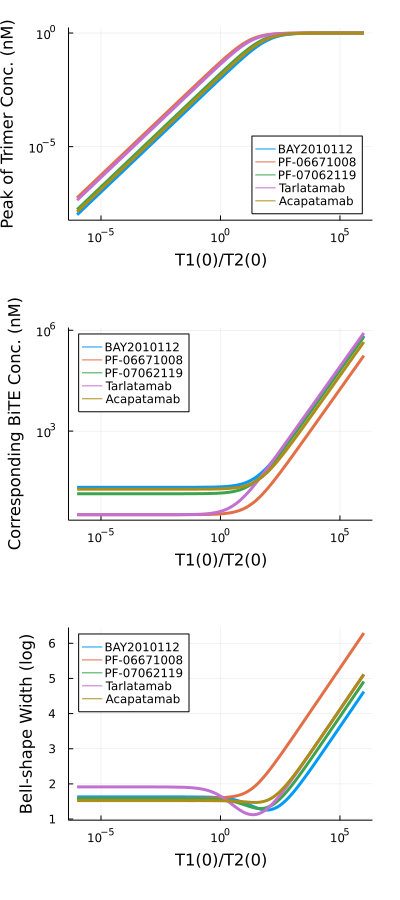

In [8]:
function compare(df_, name_)
    p1 = plot(xlabel="T1(0)/T2(0)", ylabel="Peak of Trimer Conc. (nM)"
        , xscale=:log10, yscale=:log10, legend=:bottomright)
    p2 = plot(xlabel="T1(0)/T2(0)", ylabel="Corresponding BiTE Conc. (nM)"
        , xscale=:log10, yscale=:log10, legend=:topleft)
    p3 = plot(xlabel="T1(0)/T2(0)", ylabel="Bell-shape Width (log)"
        , xscale=:log10, legend=:topleft)
    for i=1:size(df_,1)
        drange, trimer, opdrug, pwidth = sweepinitials(dproblem,[df_.kD1[i], df_.kD2[i]])
        p1 = plot!(p1, drange, trimer, label=df_.molecule[i], linewidth=3)
        p2 = plot!(p2, drange, opdrug, label=df_.molecule[i], linewidth=3)
        p3 = plot!(p3, drange, pwidth, label=df_.molecule[i], linewidth=3)
    end
    p = plot(p1,p2,p3,layout=(3,1), size=(400,900), margin=5mm)
    savefig(p, "figures/"*name_*".png")
    savefig(p, "figures/"*name_*".pdf")
    display(p)
end

compare(df[df.tumor_type .=="Solid",:], "compare-solid")

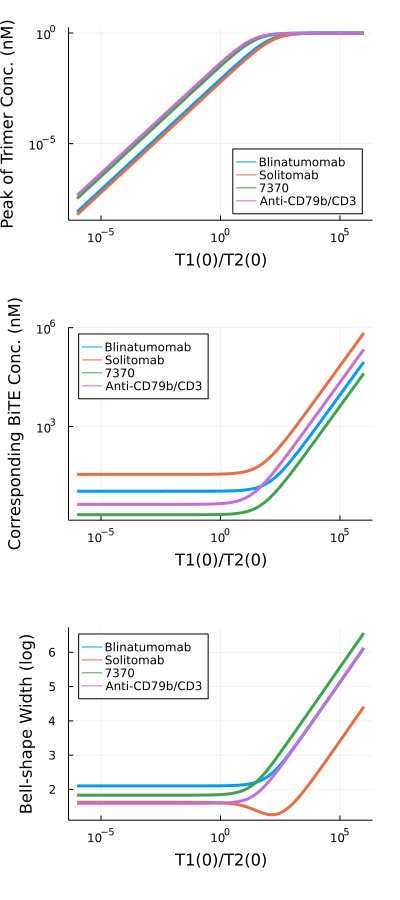

In [9]:
compare(df[df.tumor_type .=="Liquid",:], "compare-liquid")

# Adjourn

In [10]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2022/June/12 15:35"